In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


# Propagating samples through the model function

Assume the measurement model, i.e. the relation between the input quantities and the measurand, to be given as
$$ Y = f(X_1,X_2,\ldots,X_N) $$

with joint PDF associated with the input quantities given as $g_{\mathbf{X}}(\mathbf{\xi})$.

The aim of the Monte Carlo method is the propagation of samples from the PDF $g_{\mathbf{X}}(\mathbf{\xi})$ through the measurement model $f()$ as a means to calculate samples from the PDF $g_{Y}(\eta)$.

Basically, two types of implementation have to be considered: for-loops and vectorisation.

#### Monte Carlo using for-loops

This is the most easiest way of implementing Monte Carlo for a given function $f()$.

``` python
    Y = np.zeros(number_of_runs)
    X1,X2,...,XN = draw_from_gX(number_of_runs)
    for k in range(number_of_runs):
        Y[k] = model_function(X1[k],X2[k],...,XN[k])
```

#### Monte Carlo using vectorisation

For scripting languages, such as Python, Matlab or LabView, a for-loop is often very inefficient. Instead, a vectorisation of the model function should be considered.

For instance, let the model function be
$$ Y = X_1 \sin (2\pi X_2) - X_3^2 $$

The vectorized Monte Carlo method for this model is given as
``` python
    X1,X2,X3 = draw_from_gX(number_of_runs)
    Y = X1*np.sin(2*np.pi*X2) - X3**2
```

### Exercise 3.1

Carry out a Monte Carlo propagation of samples through the model
$$ Y = \frac{X_2^2}{\sqrt{1-X_1^2}}$$
with knowledge about the input quantities given as

* The value of $X_1$ satisfies $-0.8 \leq x_1 \leq  0.8$

* $X_2$ has best estimate $x_2 = 3.4$ with associated standard uncertainty $\sigma=0.5$ determined from 12 repeated measurements


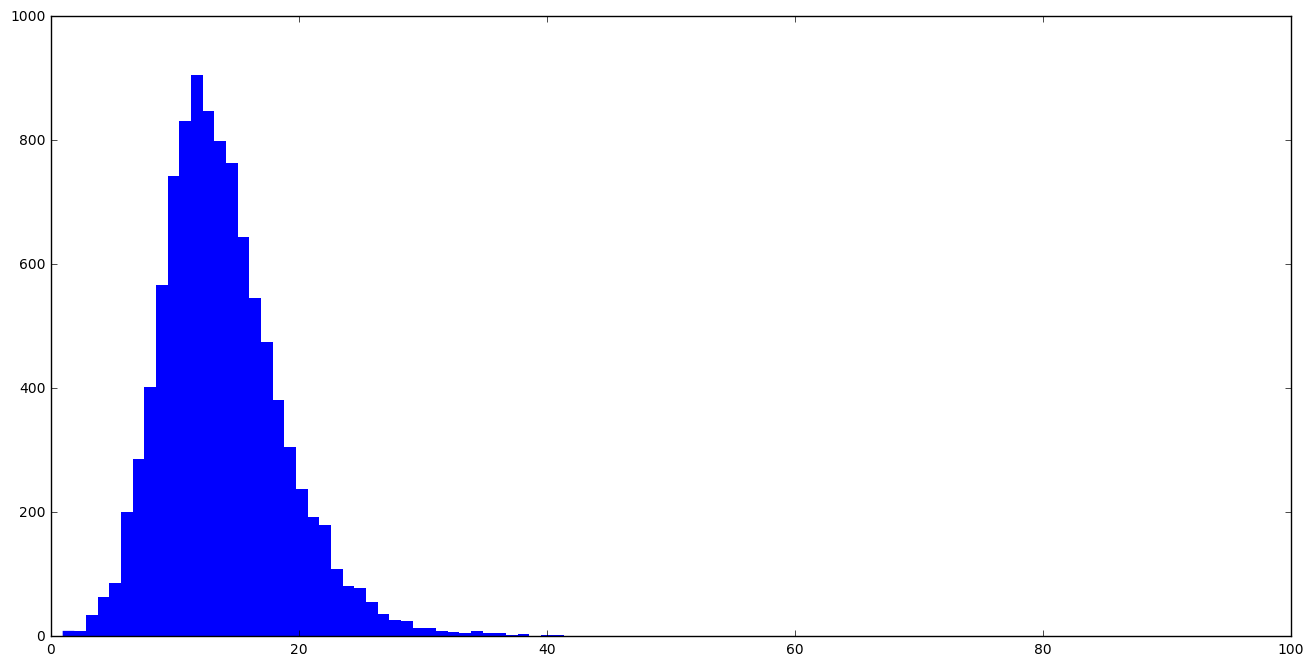

In [18]:
from scipy.stats import uniform, t

X1dist = uniform(loc=-0.8, scale=1.6)
X2dist = t(11, loc=3.4, scale=0.5)
draws = 10000

X1 = X1dist.rvs(draws)
X2 = X2dist.rvs(draws)

Y = X2**2 / (sqrt(1-X1**2))

hist(Y, bins=100, edgecolor="none");

### Exercise 3.2

Carry out a Monte Carlo propagation for the following parameter estimation problem.

For a measurement device under test, a parametrised calibration curve is to be determined by means of a non-linear least-squares fit to a set of measured pairs $(t_i, x_i)$ assuming as functional relationship
$$ x_i = f(t_i) = a\cdot\exp (-b t_i)\cdot \sin (c t_i) $$
The measurement data is assumed to be disturbed by white noise with a standard deviation of $\sigma=0.3$. The values $x_i$ are all assumed to be obtained independently, i.e. to be uncorrelated.

For the fitting of the parameters use
``` python
    from scipy.optimize import curve_fit
    
    noise = sigma*ones_like(x)
    phat,cphat = curve_fit(modelfun, t, x, sigma=noise)        
```

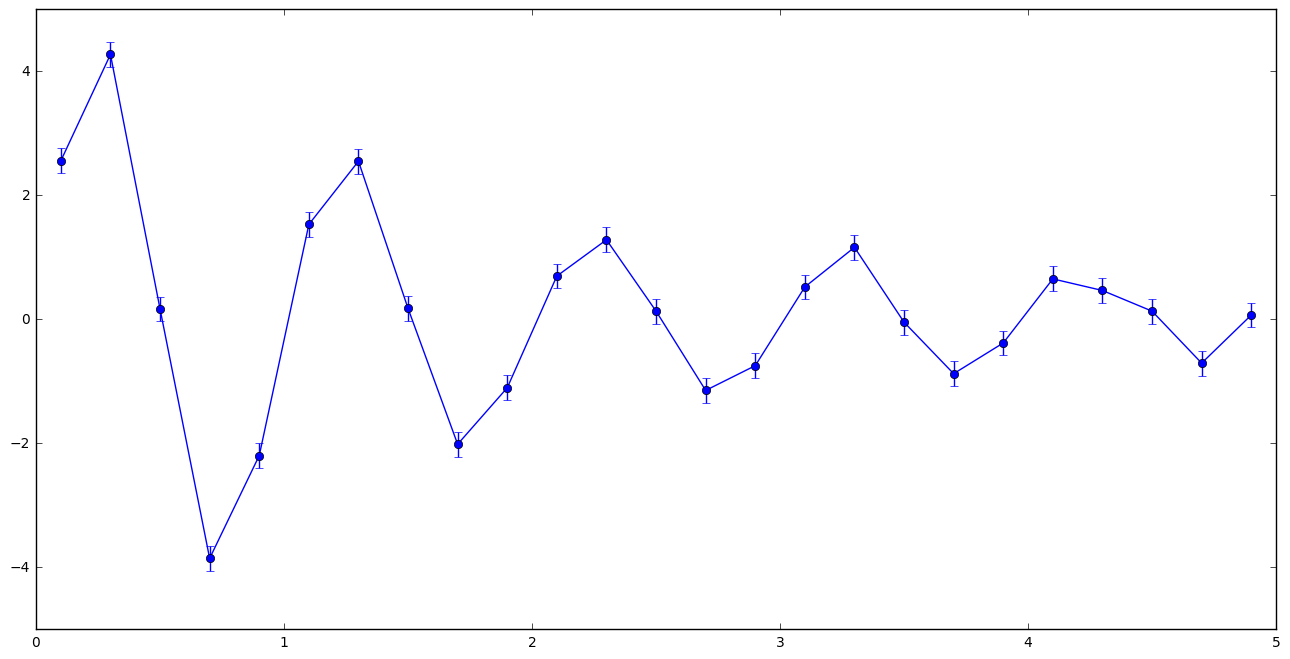

In [3]:
data = loadtxt("test_data.txt",delimiter=",")
t = data[:,0]
x = data[:,1]
# alternatively: t = linspace(0,5,25); x = 5.0 * exp(-0.5*t) * sin(2*pi*t) + random.randn(len(t))*0.3
sigma = 0.3
errorbar(t,x,sigma*ones_like(t),fmt="o-");

In [4]:
from scipy.optimize import curve_fit
curve_fit?

In [5]:
noise = 0.2
modelfun = lambda ti,a,b,c: a*exp(-b*ti)*sin(c*ti) 

# linearization result (à la GUM)
phat,uphat = curve_fit(modelfun, t, x, sigma=noise)

draws = 1000
pMC = zeros((draws, 3))
success= []
failed = []
for k in range(draws):
    xMC = x + random.randn(len(x))*sigma
    try:
        pMC[k,:] = curve_fit(modelfun, t, xMC, sigma=noise)[0]
        success.append(k)
    except RuntimeError:
        failed.append(k)        

phatMC = mean(pMC[success],axis=0)
uphatMC= cov(pMC[success],rowvar=0) 

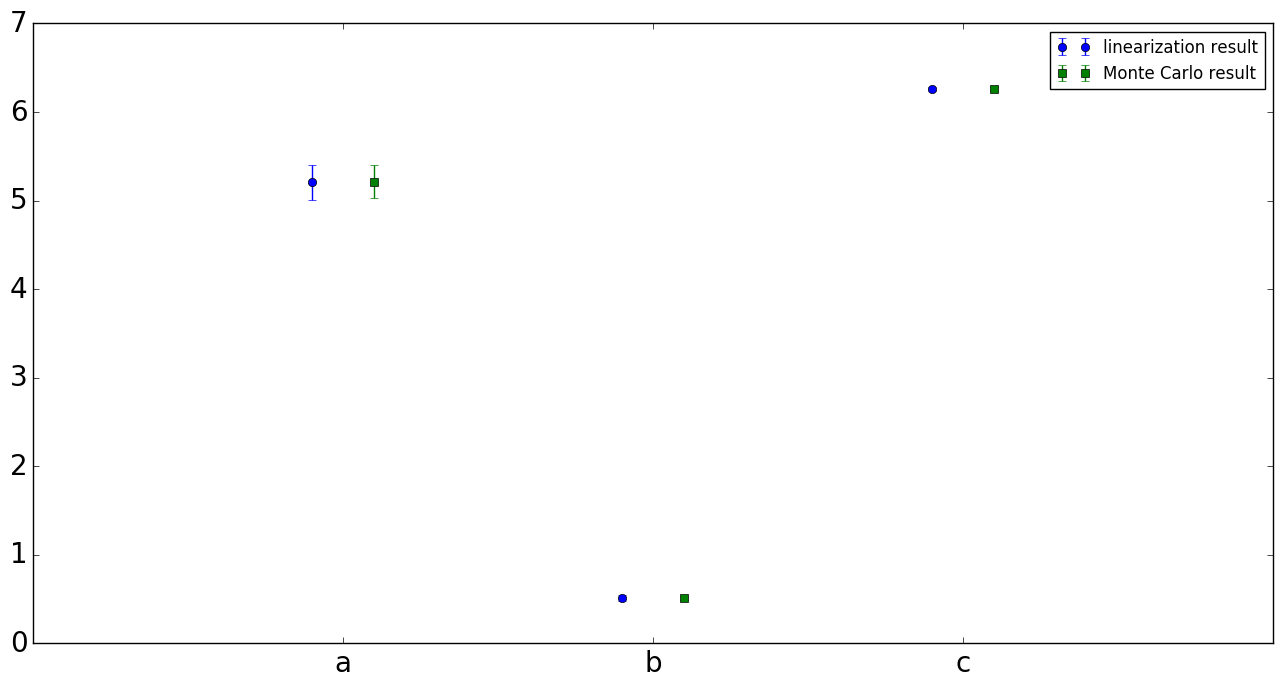

In [9]:
figure(figsize=(16,8))
errorbar(arange(1,4)-0.1, phat, sqrt(diag(uphat)), fmt="o", label="linearization result")
errorbar(arange(1,4)+0.1, phatMC, sqrt(diag(uphatMC)), fmt="s", label="Monte Carlo result")
legend()
xlim(0,4)
xticks([1,2,3], ["a", "b", "c"]);
tick_params(which="both",labelsize=20)

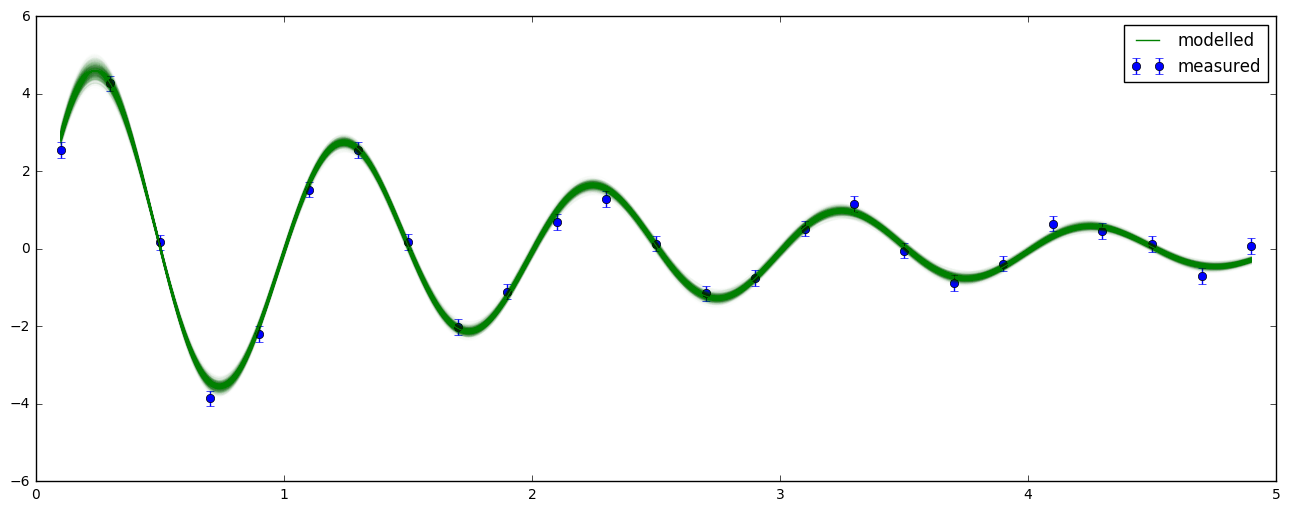

In [15]:
time = linspace(t[0], t[-1], 500)
XMC = zeros((len(time), len(success)))
for k in range(len(success)):
    XMC[:,k] = modelfun(time, *pMC[success[k]])
    
figure(figsize=(16,6))
errorbar(t, x, sigma*ones_like(x),fmt="o", label="measured")
plot(time, modelfun(time, *phatMC), "g", label="modelled")
legend()
plot(time, XMC,color="g", alpha=0.01);